In [0]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 66.6MB/s 
     |████████████████████████████████| 3.8MB 36.6MB/s 
     |████████████████████████████████| 450kB 39.6MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0rc3
    Uninstalling tensorflow-1.15.0rc3:
      Successfully uninstalled tensorflow-1.15.0rc3


# Neural Style Transfer


Neural Style Transfer ist eine Optimierungstechnik, die verwendet wird, um zwei Bilder - ein Content-Bild und ein Style-Reference-Bild (z.B. ein Artwork eines berühmten Malers) - aufzunehmen und so zusammenzufügen, dass das Ausgabebild wie das Content-Bild aussieht, aber im Stil des Style-Reference-Bildes "gemalt" wird.

Das Output-Bildes wird solang optimiert, sodass es die Inhalts-Eigenschaften des Content-Bildes, sowie die Stil-Eigenschaften des Style-Bildes enthält. Dies ist Möglich in dem wir die Eigenschaften aus den mittleren Layers eines CNNs laden!

## Beispiel

Nehmen wir folgenden Hund und das Artwork von Wassily Kandinsky:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="300px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), Wikimedia Commons

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="300px"/>


Wie würde Kandinsky nun den Hund zeichen?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 300px;"/>

## Vorbereitung
### Imports und co

In [1]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

import tensorflow as tf
import numpy as np
import PIL.Image
import functools
import time

In [2]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
# images paths
content_path = 'base3.jpg'
style_path = 'style2.jpg'

## Input anzeigen

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

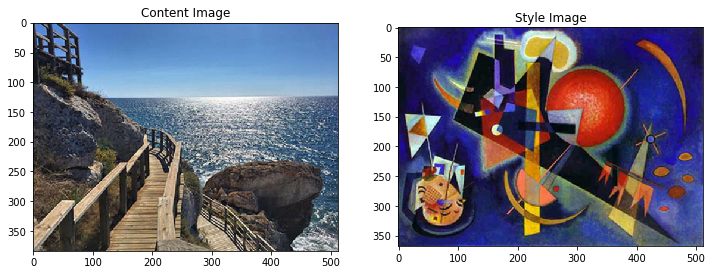

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [ ]:
## Content- und Style-Features

In [8]:
# load VGG19 and test input 
x = preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [0]:
predicted_top_5 = decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('breakwater', 0.30605534),
 ('promontory', 0.2664533),
 ('cliff', 0.102925085),
 ('suspension_bridge', 0.083478235),
 ('pier', 0.042011894)]

In [9]:
# load VGG19 without classification header
vgg = VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Model erstellen

In [11]:
def vgg_layers(layer_names):
  vgg = VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = Model([vgg.input], outputs)

  return model

In [0]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 368, 512, 64)
  min:  0.0
  max:  827.88885
  mean:  25.539017

block2_conv1
  shape:  (1, 184, 256, 128)
  min:  0.0
  max:  4246.039
  mean:  129.43774

block3_conv1
  shape:  (1, 92, 128, 256)
  min:  0.0
  max:  10017.176
  mean:  154.18518

block4_conv1
  shape:  (1, 46, 64, 512)
  min:  0.0
  max:  15206.468
  mean:  571.5555

block5_conv1
  shape:  (1, 23, 32, 512)
  min:  0.0
  max:  4333.201
  mean:  50.41543



## Style berechnen

Es stellt sich heraus, dass der Stil eines Bildes mit Hilfe von Mittelwerten und Relationen zwischen den verschiedenen Feature Maps beschrieben werden kann. Die Gram-Matrix, die diese Informationen enthält, berechnet man, indem man das äußere Produkt des Featurevektors an jeder Stelle mit sich selbst nimmt und dieses äußere Produkt über alle Positionen mittelt. Diese Gramm-Matrix kann für einen bestimmten Layer berechnet werden als:
$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

Beispiel: Der Output eines Conv-Layers ist: 

$$ F = 8 \times 8 \times 16 \Rightarrow 16 \times 64 $$
$$ F^{T} = 64 \times 16 $$
$$ G = F^{T} \times F $$

<img src="https://i.ibb.co/chg6Htp/Untitled-Diagram.png" height="250px"/>

[Sayak Paul, June 21st, 2019](https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow), DataCamp

In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  result = result / num_locations
  return result

## Style und Content Features extrahieren

Hierfür werden wir die Model Klasse nutzen und daraus eine eigene Unterklasse **StyleContentModel** davon erstellen. Diese Klasse liefert uns für unser Bild die Features von den Style (Gram-Matrix) bzw. Content Layers zurück!

In [13]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255
    preprocessed_inputs = preprocess_input(inputs)
    outputs = self.vgg(preprocessed_inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style':style_dict}


In [14]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.063244976
    max:  14150.961
    mean:  675.4869

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  139700.69
    mean:  18558.479

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  353379.97
    mean:  14606.06

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3238204.8
    mean:  188077.61

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  69689.85
    mean:  1345.4465

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1091.4834
    mean:  12.656628


## Style Transfer Algorithmus
Mit dem gerade erstellten Extraktor können wir nun den Style Transfer durchführen!

In [15]:
# Style und Content Target
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [16]:
image = tf.Variable(content_image)

In [17]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Lass uns nun den Optimizer erstellen:

In [18]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [19]:
style_weight = 1e-2
content_weight = 1e4

Jetzt berechnen wir den Style Loss und den Content Loss, damit unser Optimizer es optimieren kann. 

Um die Content- und Style-Funktionen in einem einzigen Bild zu kombinieren, musst du mit einem Target-Image beginnen, das entweder nur ein leeres oder die Kopie des Content-Image ist. Um nun sowohl die Content- als auch die Style-Features mit einem CNN effektiv zu lernen, benötigt man eine benutzerdefinierte Loss-Funktion, die man optimiert, um ein flüssiges und stilsicheres Bild aus dem Content und den Style Bildern zu erhalten. Diese benutzerdefinierte Loss-Funktion ist im Wesentlichen eine Zusammenführung von zwei verschiedenen Verlusten:

*   Content-Loss stellt sicher, dass die Menge an Content erhalten bleibt.
*   Style-Loss, kümmert sich um die Menge des Stils, das auf dem Target-Image übertragen wird.

**Style Loss:**
$$ \mathcal{L}_{style} = \frac{w_i \sum (G_{s, i} - G_{t, i})^2}{\text{# style layers}}$$
**Content Loss:**
$$ \mathcal{L}_{content} = \frac{w_i \sum (I_{c, i} - I_{t, i})^2}{\text{# content layers}}$$


In [20]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']

  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers

  loss = style_loss + content_loss
  return loss

In [21]:
@tf.function
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

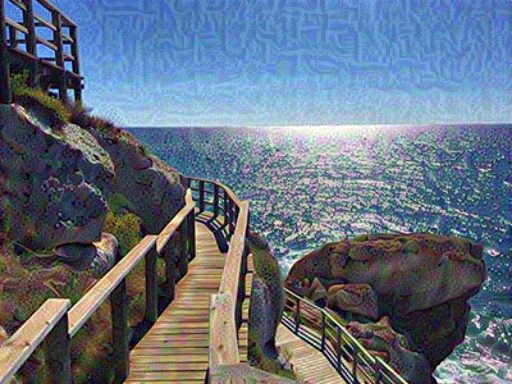

In [22]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

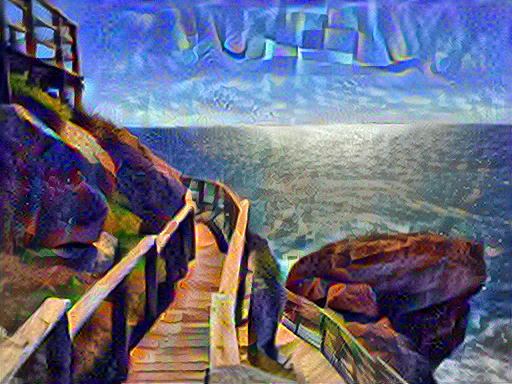

Train Step: 300


In [23]:
steps = 300

step = 0

for s in range(steps):
  step += 1
  train_step(image)
  print(".", end='')
display.clear_output(wait=True)
display.display(tensor_to_image(image))
print("Train Step: {}".format(step))

## Total Variation Loss

Ein Nachteil dieser grundlegenden Implementierung ist, dass sie viele hochfrequente Artefakte (Noise) erzeugt. Wir versuchen nun es zu verringern mit einem expliziten Regularisierungs-Term für die hochfrequenten Teile des Bildes. Beim Style-Transfer wird dies oft als *Total Variation Loss* bezeichnet:

In [24]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

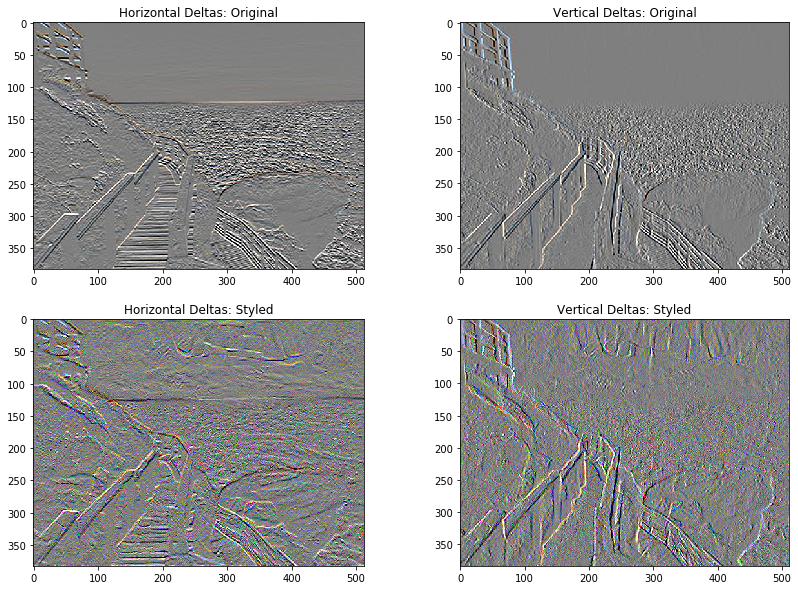

In [25]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

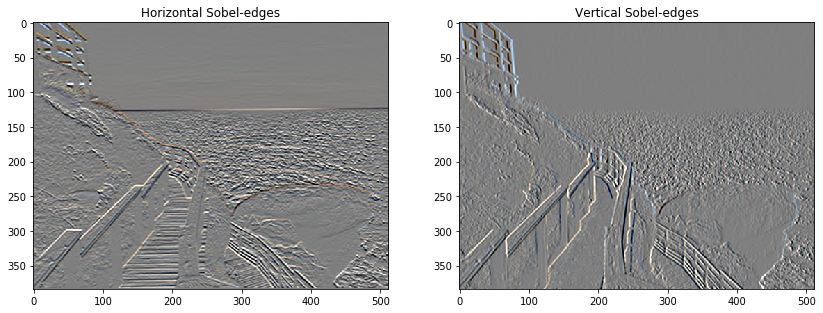

In [26]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [27]:
# Berechne "Noise-Loss"
tf.image.total_variation(image).numpy()

array([64055.965], dtype=float32)

## Optimierung wiederholen

In [28]:
total_variation_weight = 30

In [29]:
@tf.function
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

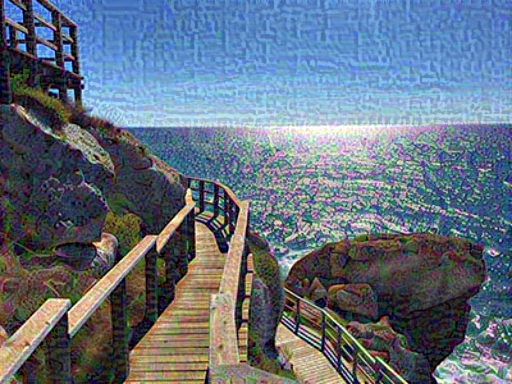

1 / 1


In [39]:
image = tf.Variable(content_image)

epochs = 10
steps_per_epoch = 50

step = 0
for e in range(epochs):
  for s in range(steps_per_epoch):
    step += 1
    train_step(image)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("{} / {}".format(step, (epochs * steps_per_epoch)))

# save image
dtyped_image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
encoded_img = tf.io.encode_jpeg(dtyped_image[0])
tf.io.write_file('drawn_image.jpg', encoded_img)